# Tutorial 6: Denoising

This tutorial demonstrates how to denoise expressions. The data used here is the same as those in Tutorial 1 (Sample 151676 of the DLPFC dataset).

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

In [4]:
section_id = '151676'

In [5]:
input_dir = os.path.join('Data', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
adata = adata[:,adata.var['total_counts']>100]
adata

View of AnnData object with n_obs × n_vars = 3460 × 10747
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
#Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [9]:
# read the annotation
Ann_df = pd.read_csv(os.path.join('Data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [10]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

... storing 'Ground Truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


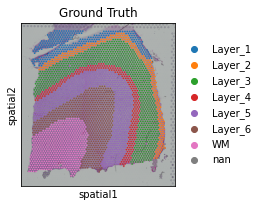

In [11]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


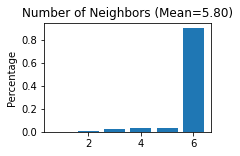

In [12]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

## Denoising expression using STAGATE

When performing imputation and denoising, set save_reconstrction=True. The reconstructed expressions are saved in 'STAGATE_ReX' of adata.layers.

In [13]:
adata = STAGATE.train_STAGATE(adata, alpha=0, save_reconstrction=True)

Size of Input:  (3460, 10747)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:51<00:00,  9.69it/s]


In [14]:
adata

AnnData object with n_obs × n_vars = 3460 × 10747
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'log1p', 'Ground Truth_colors', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'
    layers: 'STAGATE_ReX'

[<AxesSubplot:title={'center':'STAGATE_ATP2B4'}, xlabel='spatial1', ylabel='spatial2'>]

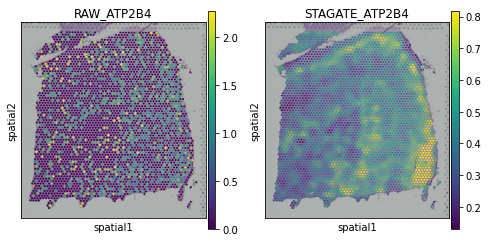

In [15]:
plot_gene = 'ATP2B4'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_RASGRF2'}, xlabel='spatial1', ylabel='spatial2'>]

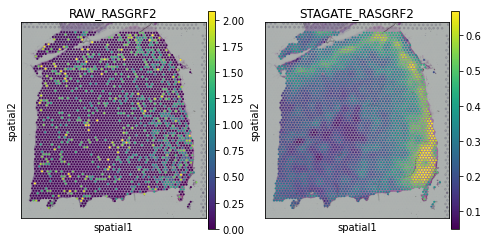

In [16]:
plot_gene = 'RASGRF2'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_LAMP5'}, xlabel='spatial1', ylabel='spatial2'>]

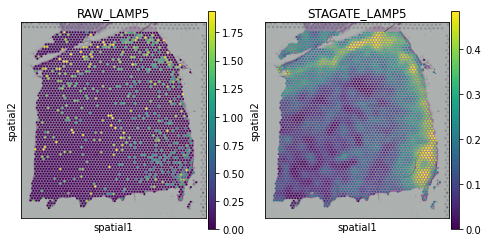

In [17]:
plot_gene = 'LAMP5'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_NEFH'}, xlabel='spatial1', ylabel='spatial2'>]

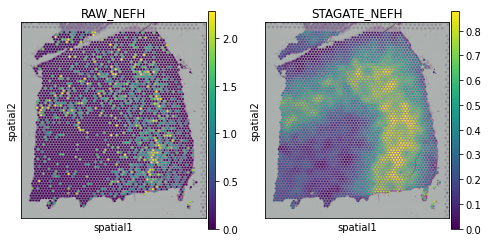

In [18]:
plot_gene = 'NEFH'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_NTNG2'}, xlabel='spatial1', ylabel='spatial2'>]

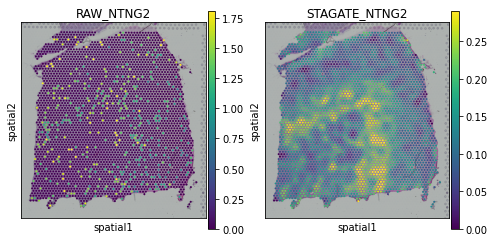

In [19]:
plot_gene = 'NTNG2'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_B3GALT2'}, xlabel='spatial1', ylabel='spatial2'>]

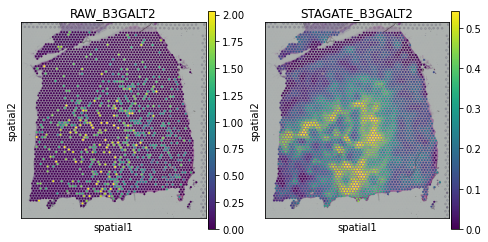

In [20]:
plot_gene = 'B3GALT2'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')